#  - Adversarial Attack

# 下載資料並解壓縮

In [ ]:
# 下載資料
!gdown --id '14CqX3OfY9aUbhGp4OpdSHLvq2321fUB7' --output data.zip
# 解壓縮
!unzip -qq -u data.zip
# 確認目前的檔案
!ls

Downloading...
From: https://drive.google.com/uc?id=14CqX3OfY9aUbhGp4OpdSHLvq2321fUB7
To: /content/data.zip
17.9MB [00:00, 25.0MB/s]
data  data.zip	sample_data


In [ ]:
import os
# 讀取 label.csv
import pandas as pd
# 讀取圖片
from PIL import Image
from PIL import ImageOps
import numpy as np

import torch
# Loss function
import torch.nn.functional as F
# 讀取資料
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
# 載入預訓練的模型
import torchvision.models as models
# 將資料轉換成符合預訓練模型的形式
import torchvision.transforms as transforms
# 顯示圖片
import matplotlib.pyplot as plt

device = torch.device("cuda")

# 讀取資料庫

In [ ]:
# 實作一個繼承 torch.utils.data.Dataset 的 Class 來讀取圖片
class Adverdataset(Dataset):
    def __init__(self, root, label, transforms):
        # 圖片所在的資料夾
        self.root = root
        # 由 main function 傳入的 label
        self.label = torch.from_numpy(label).long()
        # 由 Attacker 傳入的 transforms 將輸入的圖片轉換成符合預訓練模型的形式
        self.transforms = transforms
        # 圖片檔案名稱的 list
        self.fnames = []

        for i in range(200):
            self.fnames.append("{:03d}".format(i))

    def __getitem__(self, idx):
        # 利用路徑讀取圖片
        img = Image.open(os.path.join(self.root, self.fnames[idx] + '.png'))
        # 將輸入的圖片轉換成符合預訓練模型的形式
        img = self.transforms(img)
        # 圖片相對應的 label
        label = self.label[idx]
        return img, label
    
    def __len__(self):
        # 由於已知這次的資料總共有 200 張圖片 所以回傳 200
        return 200

# 載入模型並執行 FGSM 攻擊

In [ ]:
class Attacker:
    def __init__(self, img_dir, label):
        # 讀入預訓練模型 vgg16
        self.model = models.vgg16(pretrained = True)
        self.model.cuda()
        self.model.eval()
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        # 把圖片 normalize 到 0~1 之間 mean 0 variance 1
        self.normalize = transforms.Normalize(self.mean, self.std, inplace=False)
        transform = transforms.Compose([                
                        transforms.Resize((224, 224), interpolation=3),
                        transforms.ToTensor(),
                        self.normalize
                    ])
        # 利用 Adverdataset 這個 class 讀取資料
        self.dataset = Adverdataset('./data/images', label, transform)
        
        self.loader = torch.utils.data.DataLoader(
                self.dataset,
                batch_size = 1,
                shuffle = False)

    # FGSM 攻擊
    def fgsm_attack(self, image, epsilon, data_grad):
        # 找出 gradient 的方向
        sign_data_grad = data_grad.sign()
        # 將圖片加上 gradient 方向乘上 epsilon 的 noise
        perturbed_image = image + epsilon * sign_data_grad
        return perturbed_image
    
    def attack(self, epsilon):
        # 存下一些成功攻擊後的圖片 以便之後顯示
        adv_examples = []
        wrong, fail, success = 0, 0, 0
        for (data, target) in self.loader:
            data, target = data.to(device), target.to(device)
            data_raw = data;
            data.requires_grad = True
            # 將圖片丟入 model 進行測試 得出相對應的 class
            output = self.model(data)
            init_pred = output.max(1, keepdim=True)[1]

            # 如果 class 錯誤 就不進行攻擊
            if init_pred.item() != target.item():
                wrong += 1
                data_raw = data_raw * torch.tensor(self.std, device = device).view(3, 1, 1) + torch.tensor(self.mean, device = device).view(3, 1, 1)
                data_raw = data_raw.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), data_raw , data_raw) )
                continue
            
            # 如果 class 正確 就開始計算 gradient 進行 FGSM 攻擊
            loss = F.cross_entropy(output, target)
            self.model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            perturbed_data = self.fgsm_attack(data, epsilon, data_grad)

            # 在此轉為圖片會有overflow的問題
            # perturbed_data = topilimageFunction(perturbed_data.cpu().squeeze()) # 先轉回圖片，因此函數會先將tensor轉為numpy再轉為image，而在轉numpy過程中要求資料在cpu要有一份
            #perturbed_data = resizeFunction(perturbed_data) # 調整圖片大小為(200, 200)
            #perturbed_data = ImageOps.pad(perturbed_data, (224, 224)) # pad回(224, 224)
            # perturbed_data = totensorFunction(perturbed_data) # 轉回tensor          
            # perturbed_data = perturbed_data.view(1, 3, 224, 224).cuda() # 轉回output吃的格式
            
            # 再將加入 noise 的圖片丟入 model 進行測試 得出相對應的 class        
            output = self.model(perturbed_data)
            final_pred = output.max(1, keepdim=True)[1]
          
            if final_pred.item() == target.item():
                # 辨識結果還是正確 攻擊失敗
                fail += 1
            else:
                # 辨識結果失敗 攻擊成功
                success += 1
                # 將攻擊成功的圖片存入
                # 將攻擊成功的圖片存入
                # if len(adv_examples) < 5:
                #   adv_ex = perturbed_data * torch.tensor(self.std, device = device).view(3, 1, 1) + torch.tensor(self.mean, device = device).view(3, 1, 1)
                #   # perturbed_data 格式為 [1, 3, 6, 6]，可拆開最外層來乘
                #   adv_ex = adv_ex.squeeze().detach().cpu().numpy() 
                #   data_raw = data_raw * torch.tensor(self.std, device = device).view(3, 1, 1) + torch.tensor(self.mean, device = device).view(3, 1, 1)
                #   data_raw = data_raw.squeeze().detach().cpu().numpy()
                #   adv_examples.append( (init_pred.item(), final_pred.item(), data_raw , adv_ex) )

            adv_ex = data * torch.tensor(self.std, device = device).view(3, 1, 1) + torch.tensor(self.mean, device = device).view(3, 1, 1)
            # data 格式為 [1, 3, 6, 6]，可拆開最外層來乘
            adv_ex = adv_ex.squeeze().detach().cpu().numpy() 
            data_raw = data_raw * torch.tensor(self.std, device = device).view(3, 1, 1) + torch.tensor(self.mean, device = device).view(3, 1, 1)
            data_raw = data_raw.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), data_raw , adv_ex) )
        
        final_acc = (fail / (wrong + success + fail))
        # 存入被攻擊的圖片
 
        print("Epsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon, fail, len(self.loader), final_acc))
        print("wrong:" + str(wrong))
        print("fail:" + str(fail))
        print("success" + str(success))
        return adv_examples, final_acc


# 執行攻擊 並顯示攻擊成功率

In [ ]:
if __name__ == '__main__':
    # 讀入圖片相對應的 label
    df = pd.read_csv("./data/labels.csv")
    df = df.loc[:, 'TrueLabel'].to_numpy()
    label_name = pd.read_csv("./data/categories.csv")
    label_name = label_name.loc[:, 'CategoryName'].to_numpy()
    # new 一個 Attacker class
    attacker = Attacker('./data/images', df)
    # 要嘗試的 epsilon
    epsilons = [0.1, 0.01]

    accuracies, examples = [], []

    # 進行攻擊 並存起正確率和攻擊成功的圖片
    for eps in epsilons:
        ex, acc = attacker.attack(eps)
        accuracies.append(acc)
        examples.append(ex)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



Epsilon: 0.1	Test Accuracy = 3 / 200 = 0.015

wrong:27
fail:3
success170
Epsilon: 0.01	Test Accuracy = 29 / 200 = 0.145

wrong:27
fail:29
success144


# Passive Defense - Randomization

In [ ]:
from google.colab import files

totensorFunction = transforms.ToTensor() # 轉為tensor
topilimageFunction = transforms.ToPILImage() # 轉為圖片
resizeFunction = transforms.Resize((210, 210), interpolation=3)

imageNames = [] # 先幫圖片取好名字
for i in range(200):
  imageNames.append("{:03d}".format(i) + '.png')
# 此時圖片已經過反normalization以及clip，數值必和原本不同
imagelist = []
for i in range(len(examples[0])): # epsilon設為0.1之結果
  image = examples[0][i][3]
  image = np.transpose(np.clip(image, 0, 1), (1, 2, 0)) # 反normalize有時會超出1
  image = totensorFunction(image) # 先將numpy轉為tensor
  image = topilimageFunction(image) # 再將tensor轉為image
  # image = resizeFunction(image)
  # image = ImageOps.expand(image, (7, 7, 7, 7), "grey") # 左 上 右 下 (224-200)/2 = 12
  imagelist.append(image)

  # image = image.save("attacked" + imageNames[i]) 
  # files.download("attacked" + imageNames[i]) # 記得更改chrome下載之路徑

In [ ]:
model = models.vgg16(pretrained = True)
model.cuda()
model.eval()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# 把圖片 normalize 到 0~1 之間 mean 0 variance 1
normalize = transforms.Normalize(mean, std, inplace=False)
transform = transforms.Compose([                
            transforms.ToTensor(),
            normalize])
for i in range(len(imagelist)):
  imagelist[i] = transform(imagelist[i])

In [ ]:
wrong = 0
for i in range(len(imagelist)):
    data, target = imagelist[i].view(1,3, 224, 224).to(device), df[i]
    data.requires_grad = True
    # 將圖片丟入 model 進行測試 得出相對應的 class
    output = model(data)
    pred = output.max(1, keepdim=True)[1]
    if pred.item() != target.item():
        wrong += 1
print("wrong:" + str(wrong))

wrong:27


# 顯示 FGSM 產生的圖片

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


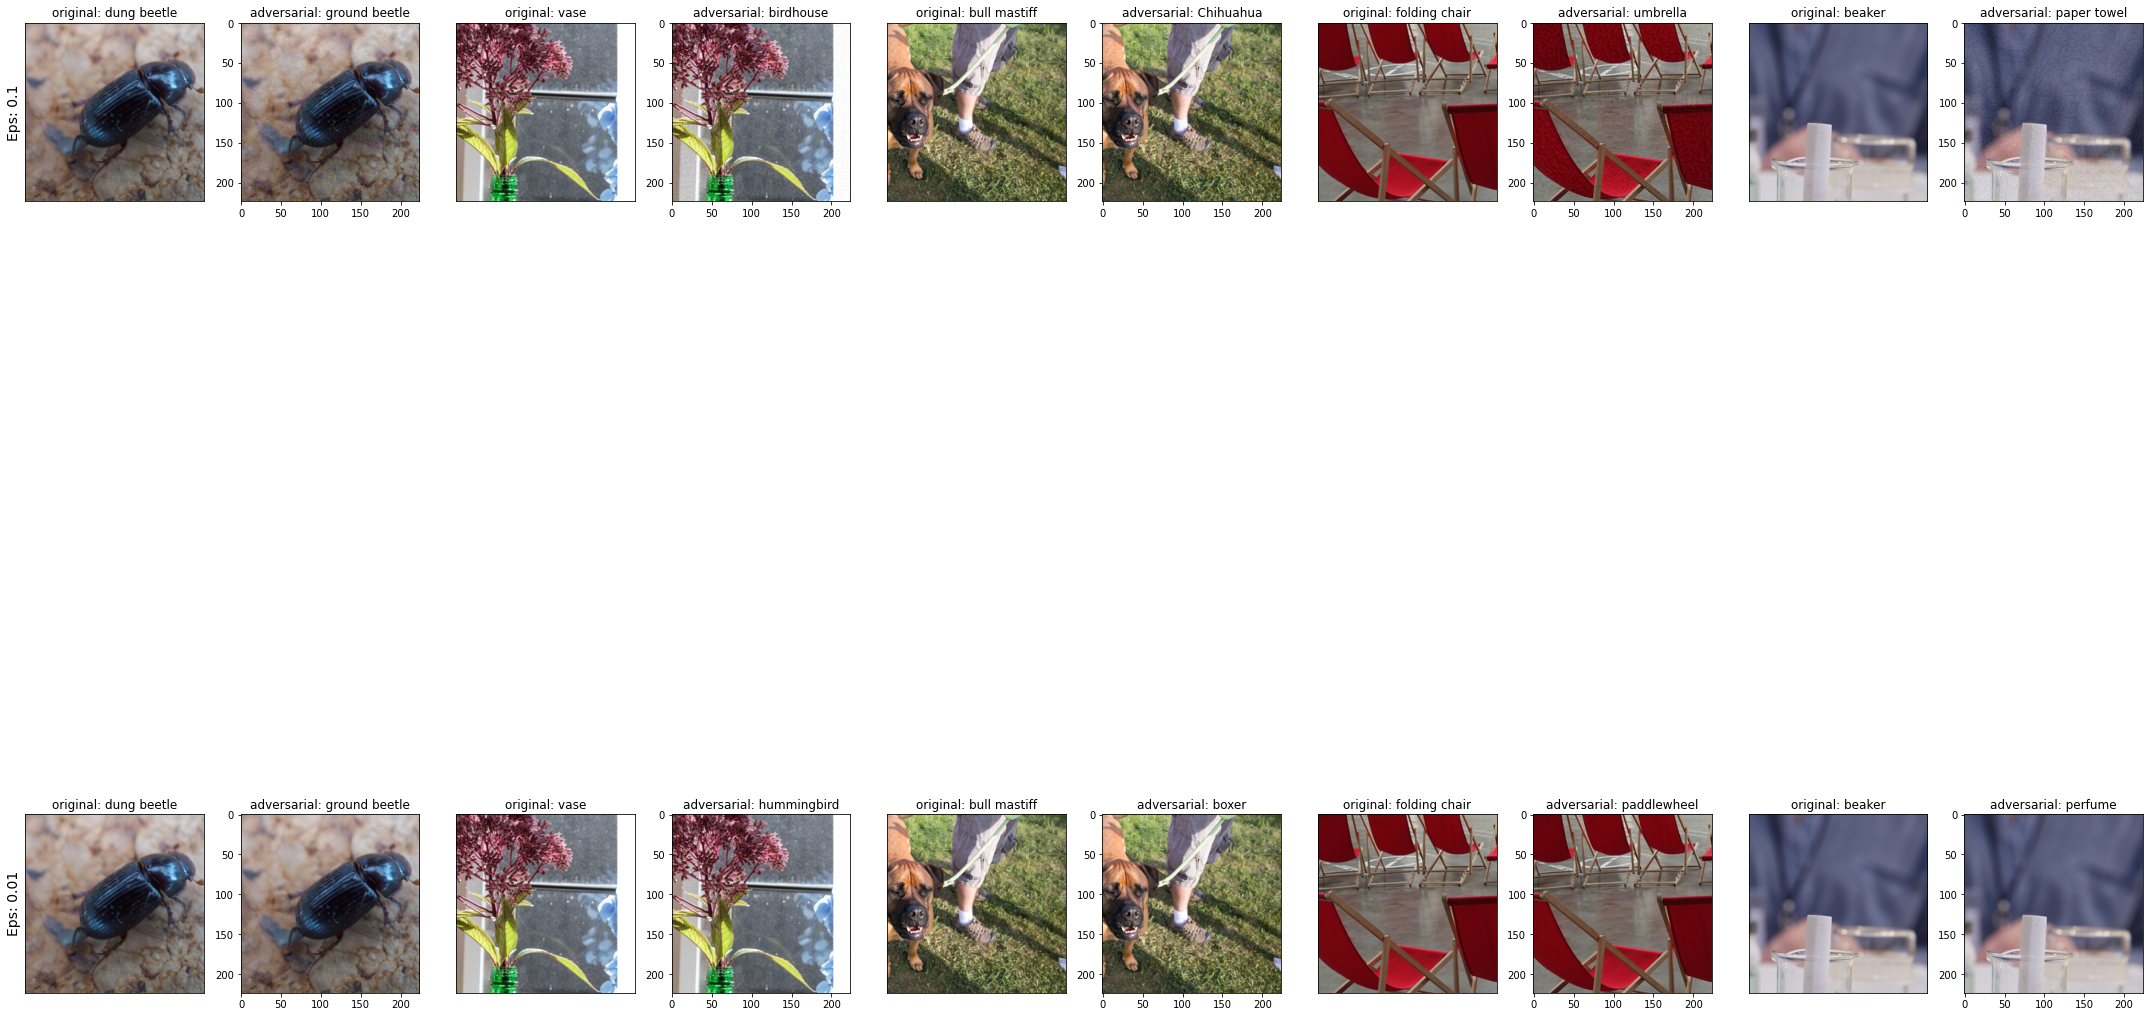

In [ ]:
cnt = 0
plt.figure(figsize=(30, 30))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,orig_img, ex = examples[i][j]
        # plt.title("{} -> {}".format(orig, adv))
        plt.title("original: {}".format(label_name[orig].split(',')[0]))
        orig_img = np.transpose(orig_img, (1, 2, 0))
        plt.imshow(orig_img)
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.title("adversarial: {}".format(label_name[adv].split(',')[0]))
        ex = np.transpose(ex, (1, 2, 0))
        plt.imshow(ex)
plt.tight_layout()
plt.show()

In [ ]:
im = examples[0][0][3] # imagefromarray

In [ ]:
im

array([[[0.68235296, 0.6784314 , 0.6666667 , ..., 0.76862746,
         0.7529412 , 0.7372549 ],
        [0.67058825, 0.6666667 , 0.6627451 , ..., 0.7647059 ,
         0.75686276, 0.73333335],
        [0.6666667 , 0.6666667 , 0.6666667 , ..., 0.7529412 ,
         0.7411765 , 0.72156864],
        ...,
        [0.44313726, 0.45882353, 0.45882353, ..., 0.43137255,
         0.49411765, 0.42745098],
        [0.41568628, 0.44313726, 0.43137255, ..., 0.4627451 ,
         0.45490196, 0.41568628],
        [0.4392157 , 0.47058824, 0.45882353, ..., 0.43137255,
         0.3882353 , 0.38039216]],

       [[0.5803922 , 0.58431375, 0.5803922 , ..., 0.7411765 ,
         0.73333335, 0.7137255 ],
        [0.5803922 , 0.5764706 , 0.57254905, ..., 0.74509805,
         0.7411765 , 0.70980394],
        [0.5764706 , 0.57254905, 0.5686275 , ..., 0.7372549 ,
         0.7254902 , 0.7019608 ],
        ...,
        [0.37254903, 0.3647059 , 0.3647059 , ..., 0.4509804 ,
         0.5176471 , 0.44705883],
        [0.3

In [ ]:
im.shape

(3, 224, 224)

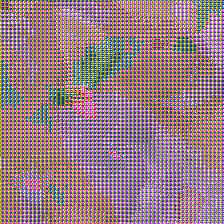

In [ ]:
Image.fromarray(np.transpose(im, (2, 1, 0)), 'RGB')